# This notebook is to use CmapPy to query LINCS1000

In [1]:
import pkg_resources
pkg_resources.get_distribution("cmapPy").version

'4.0.1'

In [2]:
import sys
sys.path.append("../..")
import pandas as pd
from sys import platform 
%load_ext autoreload
%autoreload 2
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

In [3]:
sig_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_sig_info.txt.gz", 
                       sep="\t", low_memory = False)

In [4]:
# look at the metadata fields provided 
sig_info.columns

Index(['sig_id', 'pert_id', 'pert_iname', 'pert_type', 'cell_id', 'pert_dose',
       'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_time_unit',
       'pert_itime', 'distil_id'],
      dtype='object')

In [96]:
sig_info.cell_id.unique()

array(['CD34', 'HL60', 'PC3', 'U937', 'MCF7', 'A375', 'HEK293T', 'A549',
       'ASC', 'HA1E', 'HCC515', 'HEKTE', 'HEPG2', 'HT29', 'NCIH716',
       'NPC', 'SHSY5Y', 'SKL', 'SW480', 'VCAP', 'BT20', 'FIBRNPC',
       'HS578T', 'MCF10A', 'MCH58', 'MDAMB231', 'NEU', 'NKDBA', 'NOMO1',
       'PHH', 'SKBR3', 'SKB', 'SKM1', 'THP1', 'A673', 'AGS', 'CL34',
       'CORL23', 'COV644', 'DV90', 'EFO27', 'H1299', 'HCC15', 'HCT116',
       'HEC108', 'HT115', 'JHUEM2', 'LOVO', 'MDST8', 'NCIH1694',
       'NCIH1836', 'NCIH2073', 'NCIH508', 'NCIH596', 'OV7', 'PL21', 'RKO',
       'RMGI', 'RMUGS', 'SKLU1', 'SKMEL1', 'SKMEL28', 'SNGM', 'SNU1040',
       'SNUC4', 'SNUC5', 'SW620', 'SW948', 'T3M10', 'TYKNU', 'WSUDLCL2',
       'HUH7', 'HS27A', 'JURKAT', 'U266', 'U2OS'], dtype=object)

In [79]:
cell_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_cell_info.txt.gz", 
                       sep="\t", low_memory = False)

In [97]:
cell_info['primary_site'].unique()

array(['skin', 'lung', 'bone', 'stomach', 'breast', 'large intestine',
       'ovary', 'kidney', 'endometrium', 'liver',
       'haematopoietic and lymphoid tissue', 'vascular system',
       'prostate', 'autonomic ganglia', 'blood', 'pancreas', '-666',
       'central nervous system', 'adipose', 'muscle'], dtype=object)

In [100]:
neu_ids = cell_info[cell_info['primary_site'].isin(['central nervous system', 'autonomic ganglia','-666'])]['base_cell_id']

In [6]:
gene_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_gene_info.txt.gz", 
                        sep="\t", dtype=str, low_memory = False)
gene_info.columns

Index(['pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm',
       'pr_is_bing'],
      dtype='object')

In [7]:
gene_info.head()

,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
2,2978,GUCA1A,guanylate cyclase activator 1A,0,0
3,2049,EPHB3,EPH receptor B3,0,1
4,2101,ESRRA,estrogen related receptor alpha,0,1


In [19]:
gene_to_query_ids = gene_info[gene_info["pr_gene_symbol"].isin(['BLOC1S2','DHRS7','NEMP1','CDC123','NUDT21','SUCLA2'])]['pr_gene_id']

In [20]:
from cmapPy.pandasGEXpress.parse import parse


In [21]:
gene_to_query_ids

728      8872
1479     8803
6361    51635
6972    23306
7480    11051
Name: pr_gene_id, dtype: object

In [26]:
%%time
critical_gene_only_gctoo = parse(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx", 
                                 rid = gene_to_query_ids)

Wall time: 1min 34s


In [28]:
# Check to make sure we only have 978 rows of expression data: 
critical_gene_only_gctoo.data_df.shape

(5, 473647)

In [32]:
critical_gene_only_gctoo.data_df.head(2)

cid,CPC005_A375_6H:BRD-A85280935-003-01-7:10,CPC005_A375_6H:BRD-A07824748-001-02-6:10,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC005_A375_6H:BRD-K62929068-001-03-3:10,CPC005_A375_6H:BRD-K43405658-001-01-8:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC005_A375_6H:BRD-K51223576-001-01-3:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,CPC004_A375_6H:BRD-K79131256-001-08-8:10,...,PCLB003_PC3_24H:BRD-A52530684-003-01-7:0.04,PCLB003_PC3_24H:BRD-A75409952-001-01-6:10,PCLB003_PC3_24H:BRD-A75409952-001-01-6:3.33,PCLB003_PC3_24H:BRD-A75409952-001-01-6:1.11,PCLB003_PC3_24H:BRD-A75409952-001-01-6:0.37,PCLB003_PC3_24H:BRD-A75409952-001-01-6:0.12,PCLB003_PC3_24H:BRD-A75409952-001-01-6:0.04,PCLB003_PC3_24H:BRD-K42573370-001-01-1:10,PCLB003_PC3_24H:BRD-K53665955-001-01-4:0.04,PCLB003_PC3_24H:BRD-K04466929-001-05-1:10
rid,,,,,,,,,,,,,,,,,,,,,
51635,-0.125617,-0.564323,-1.949488,-0.518036,1.548731,1.518260,0.315039,-0.330317,-0.678309,1.652225,...,-1.121820,-0.799507,-1.227111,-0.629981,-0.823108,-0.829233,-0.848049,-10.0000,-0.9592,1.8779
8872,-0.289844,-1.531495,-0.173728,0.521163,-0.877650,0.294446,-0.549678,-0.507737,-0.589620,0.595361,...,-0.065263,-1.959731,-1.051817,0.060470,1.186062,-0.293673,0.032575,-1.4244,-0.5366,-0.4779


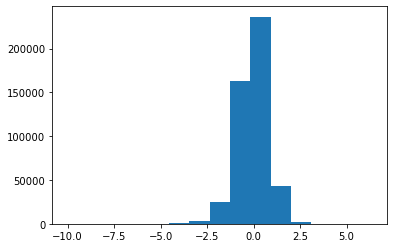

In [138]:
plt.hist(critical_gene_only_gctoo.data_df.loc['8872'], bins = 15);

# get > 90% connectivity 

In [68]:
positive_num = critical_gene_only_gctoo.data_df.loc['51635'][critical_gene_only_gctoo.data_df.loc['51635'] > 0].shape[0]

In [69]:
positive_num

234795

In [107]:
int(0.1*positive_num)

23479

In [108]:
critical_gene_only_gctoo.data_df.loc['51635'].sort_values(ascending = False)[23479]

1.4417499

In [109]:
cids = critical_gene_only_gctoo.data_df.loc['51635'][critical_gene_only_gctoo.data_df.loc['51635'] > 1.442].index

In [120]:
sig_info.head()

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
0,AML001_CD34_24H:A05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:A05
1,AML001_CD34_24H:A06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:A06
2,AML001_CD34_24H:B05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...
3,AML001_CD34_24H:B06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:B06
4,AML001_CD34_24H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,CD34,0.37037,µM,500 nM,24,h,24 h,AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...


In [121]:
cids[0] in sig_info['sig_id'].unique()

True

In [122]:
sample_of_interest = sig_info[sig_info['sig_id'].isin(cids)]

In [128]:
sample_of_interest[sample_of_interest['cell_id'].isin(neu_ids)]

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
28643,CGS001_NPC_96H:CLASRP:1.5,CGS001-11129,CLASRP,trt_sh.cgs,NPC,1.5,µL,1.5 µL,96,h,96 h,KDB008_NPC_96H:TRCN0000075089:-666|KDB008_NPC_...
28666,CGS001_NPC_96H:CREB3L2:1.5,CGS001-64764,CREB3L2,trt_sh.cgs,NPC,1.5,µL,1.5 µL,96,h,96 h,KDB007_NPC_96H:TRCN0000016439:-666|KDB007_NPC_...
28700,CGS001_NPC_96H:DHDDS:1.5,CGS001-79947,DHDDS,trt_sh.cgs,NPC,1.5,µL,1.5 µL,96,h,96 h,KDB009_NPC_96H:TRCN0000045573:-666|KDB009_NPC_...
28707,CGS001_NPC_96H:DLGAP5:1.5,CGS001-9787,DLGAP5,trt_sh.cgs,NPC,1.5,µL,1.5 µL,96,h,96 h,KDB005_NPC_96H:TRCN0000062230:-666|KDB005_NPC_...
28751,CGS001_NPC_96H:EPHA2:1.5,CGS001-1969,EPHA2,trt_sh.cgs,NPC,1.5,µL,1.5 µL,96,h,96 h,KDB007_NPC_96H:TRCN0000006403:-666|KDB007_NPC_...
...,...,...,...,...,...,...,...,...,...,...,...,...
437327,NMH002_NPC_6H:BRD-K97399794-001-12-0:10,BRD-K97399794,quercetin,trt_cp,NPC,10.0,µM,10 µM,6,h,6 h,NMH002_NPC_6H_X1_B6_DUO52HI53LO:C12|NMH002_NPC...
437332,NMH002_NPC_6H:BRD-K99667445-001-02-2:10,BRD-K99667445,licochalcone-a,trt_cp,NPC,10.0,µM,10 µM,6,h,6 h,NMH002_NPC_6H_X1_B6_DUO52HI53LO:L05|NMH002_NPC...
437347,NMH002_NPC_6H:J16,DMSO,DMSO,ctl_vehicle,NPC,-666.0,-666,-666,6,h,6 h,NMH002_NPC_6H_X1_B6_DUO52HI53LO:J16|NMH002_NPC...
437348,NMH002_NPC_6H:M09,DMSO,DMSO,ctl_vehicle,NPC,-666.0,-666,-666,6,h,6 h,NMH002_NPC_6H_X1_B6_DUO52HI53LO:M09|NMH002_NPC...


# Also, add methods to query a list of critical genes and find high connectivity score for all of them --> better candidate

# Next, determine the connectivity score for these treatments for each gene

In [116]:
len(cell_types)

23466

In [111]:
from collections import Counter
cell_type_cnt = Counter(cell_types)

In [112]:
neu_ids

61    SHSY5Y
83      MNEU
84       NEU
85       NEU
86       NPC
87       NPC
88       NPC
89     HUES3
Name: base_cell_id, dtype: object

In [113]:
cell_type_cnt['NPC']

859

In [34]:
critical_gene_only_gctoo.data_df

728      8872
1479     8803
6361    51635
6972    23306
7480    11051
Name: pr_gene_id, dtype: object